In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


# CPI (Combined Index)
cpi = pd.read_excel("C:/Users/Tenzin Choeyang D/OneDrive/Desktop/rbi/Consumer Price Index.xlsx")

# Money Supply (M3 – level or growth)
m3 = pd.read_excel("C:/Users/Tenzin Choeyang D/OneDrive/Desktop/rbi/Broad Money (M3).xlsx")

# USD/INR (monthly average)
usd = pd.read_excel("C:/Users/Tenzin Choeyang D/OneDrive/Desktop/rbi/Exchange Rate of the Indian Rupee.xlsx")

# IIP Growth Rate (General Index)
iip = pd.read_excel("C:/Users/Tenzin Choeyang D/OneDrive/Desktop/rbi/Index of Industrial Production (IIP).xlsx")

# Call Money Rate (monthly average)
call = pd.read_excel("C:/Users/Tenzin Choeyang D/OneDrive/Desktop/rbi/Weighted Average Call.xlsx")


In [2]:
cpi['Date'] = pd.to_datetime(cpi['Date'])
m3['Date'] = pd.to_datetime(m3['Date'])
usd['Date'] = pd.to_datetime(usd['Date'])
iip['Date'] = pd.to_datetime(iip['Date'])
call['Date'] = pd.to_datetime(call['Date'])


In [3]:
usd.rename(columns={'US Dollar': 'USD_INR'}, inplace=True)
iip.rename(columns={'General_Index': 'IIP_Growth'}, inplace=True)
call.rename(columns={'Average of Weighted Average Rates Borrowings/ Lendings': 'Call_Money_Rate'}, inplace=True)


In [4]:
df = (
    cpi
    .merge(m3, on='Date', how='inner')
    .merge(usd, on='Date', how='inner')
    .merge(iip, on='Date', how='inner')
    .merge(call, on='Date', how='inner')
)

df = df.sort_values('Date').reset_index(drop=True)


In [5]:
df_lag = df.copy()

for col in ['M3_Growth', 'USD_INR', 'IIP_Growth', 'Call_Money_Rate']:
    df_lag[col] = df_lag[col].shift(1)

df_lag = df_lag.dropna().reset_index(drop=True)


In [6]:
print(df.head())
print(df.tail())
print(df.info())
print("Date range:", df['Date'].min(), "to", df['Date'].max())


        Date Consumer Price Index   Inflation_Rate  M3_Growth    USD_INR  \
0 2013-04-30                 106.1             NaN   9.864300  54.375706   
1 2013-05-31                 106.9             NaN   9.042211  55.010809   
2 2013-06-30                 109.3             NaN   9.641522  58.460948   
3 2013-07-31                   111             NaN   8.353403  59.790157   
4 2013-08-31                 112.4             NaN   9.367473  63.208845   

  IIP_Growth  Call_Money_Rate  
0   3.323263         7.501723  
1   0.952381         7.253888  
2  -0.977517         7.220368  
3   3.152709         7.758077  
4   4.404404         9.426900  
          Date Consumer Price Index   Inflation_Rate  M3_Growth    USD_INR  \
145 2025-05-31                   193            2.82   9.291161  85.189685   
146 2025-06-30                 194.2            2.10   9.458112  85.903433   
147 2025-07-31                 196.1            1.61   9.606636  86.114622   
148 2025-08-31                   197   

In [7]:
# Replace RBI placeholders
df = df.replace('-', np.nan)

# Force numeric conversion
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df = df.dropna().reset_index(drop=True)

C:\Users\Tenzin Choeyang D\AppData\Local\Temp\ipykernel_11044\2217140949.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('-', np.nan)


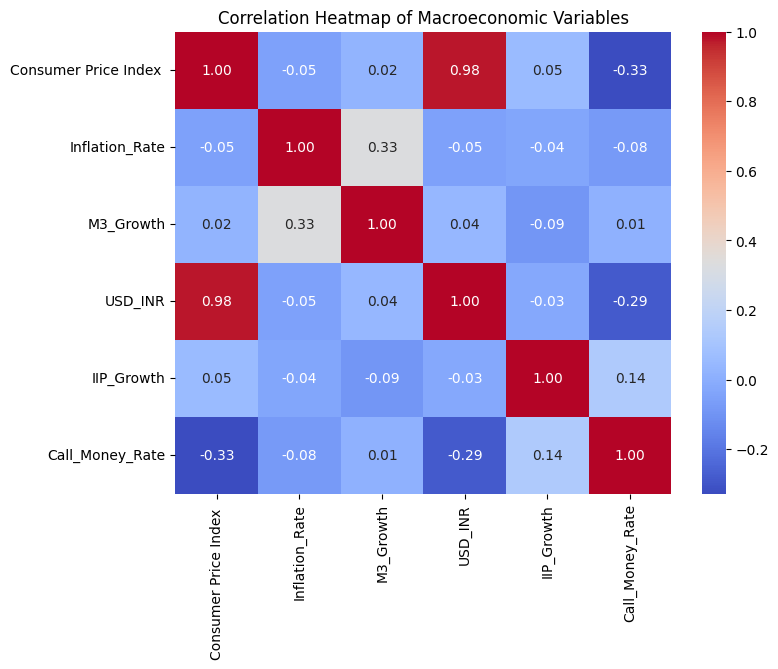

In [8]:
plt.figure(figsize=(8,6))
corr = df.drop(columns=['Date']).corr()

sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)

plt.title("Correlation Heatmap of Macroeconomic Variables")
plt.show()


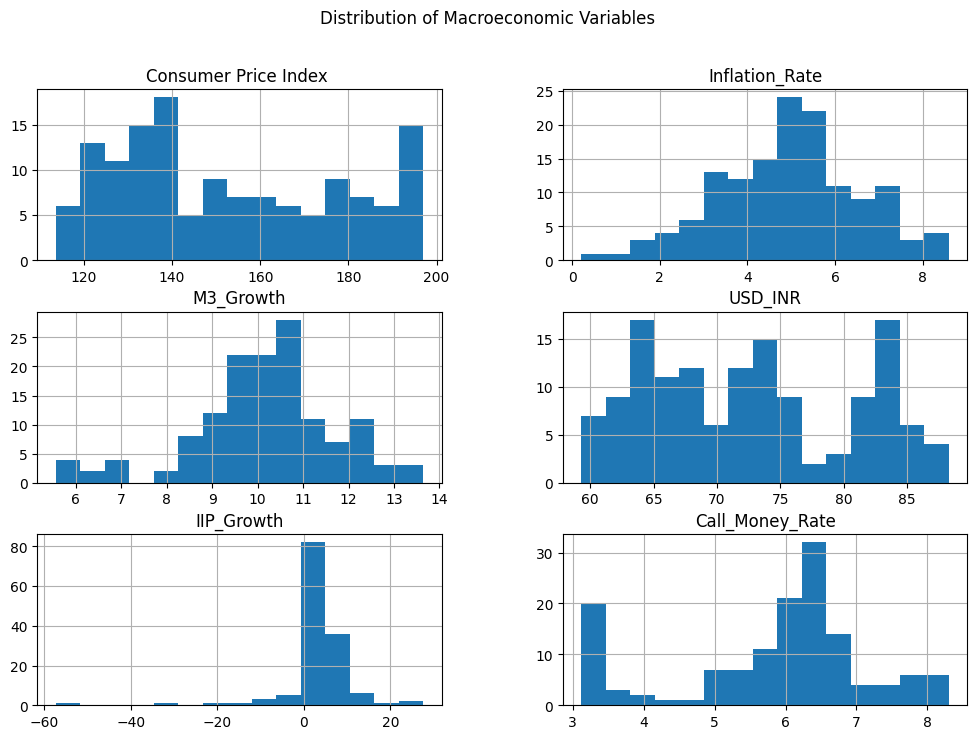

In [9]:
df.drop(columns=['Date']).hist(
    bins=15,
    figsize=(12,8)
)
plt.suptitle("Distribution of Macroeconomic Variables")
plt.show()


In [10]:
X = df.drop(columns=['Date', 'Inflation_Rate'])
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

vif_data

,Feature,VIF
0,Consumer Price Index,523.103766
1,M3_Growth,39.679559
2,USD_INR,793.915990
3,IIP_Growth,1.297339
4,Call_Money_Rate,22.952783


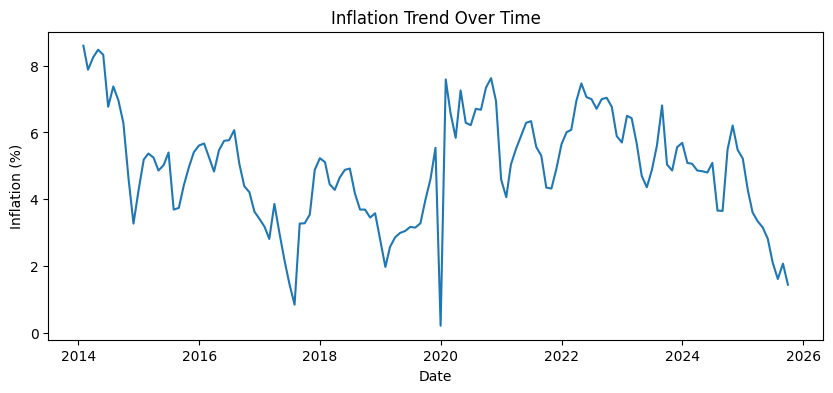

In [11]:
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Inflation_Rate'])
plt.title("Inflation Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.show()


In [12]:
df_avg = df.copy()

df_avg['Inflation_3M_Avg'] = (
    df_avg['Inflation_Rate']
    .rolling(window=3)
    .mean()
)
# Lag macro variables by 1 month
for col in ['M3_Growth', 'USD_INR', 'IIP_Growth', 'Call_Money_Rate']:
    df_avg[col] = df_avg[col].shift(1)

# Lag inflation average itself (persistence)
df_avg['Inflation_3M_lag1'] = df_avg['Inflation_3M_Avg'].shift(1)
df_avg['Inflation_3M_lag2'] = df_avg['Inflation_3M_Avg'].shift(2)

df_avg = df_avg.replace('-', np.nan)

for col in df_avg.columns:
    if col != 'Date':
        df_avg[col] = pd.to_numeric(df_avg[col], errors='coerce')

df_avg = df_avg.dropna().reset_index(drop=True)

In [ ]:
feature_cols = [
    'Inflation_3M_lag1',
    'Inflation_3M_lag2',
    'M3_Growth',
    'USD_INR',
    'IIP_Growth',
    'Call_Money_Rate'
]

X = df_avg[feature_cols]
feature_cols = X.columns.tolist()

y = df_avg['Inflation_3M_Avg']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
scalar_rf=StandardScaler()
X_train_scaled=scalar_rf.fit_transform(X_train)
X_test_scaled=scalar_rf.transform(X_test)

(135, 6)
Index(['Inflation_3M_lag1', 'Inflation_3M_lag2', 'M3_Growth', 'USD_INR',
       'IIP_Growth', 'Call_Money_Rate'],
      dtype='object')


In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,          # important for macro data
    min_samples_leaf=5,   # stabilizes predictions
    random_state=42
)

rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

rf_r2 = r2_score(y_test, rf_pred)
print("Random Forest R²:", rf_r2)


Random Forest R²: 0.8405187869882316


In [15]:
pred_df = pd.DataFrame({
    'Date': df_avg.iloc[X_test.index]['Date'].values,
    'Actual_Inflation_3M': y_test.values,
    'Predicted_Inflation_3M': rf_pred
})

pred_df.head()


,Date,Actual_Inflation_3M,Predicted_Inflation_3M
0,2023-07-31,4.946667,4.307393
1,2023-08-31,5.763333,5.292394
2,2023-09-30,5.820000,5.603390
3,2023-10-31,5.570000,5.484178
4,2023-11-30,5.153333,5.395291


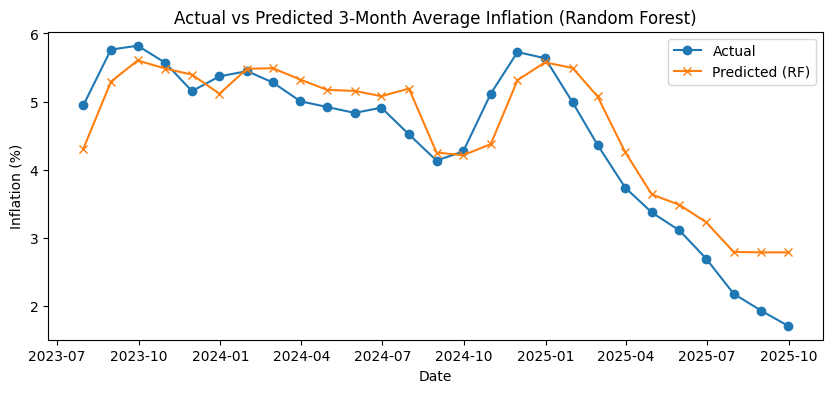

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(pred_df['Date'], pred_df['Actual_Inflation_3M'], label='Actual', marker='o')
plt.plot(pred_df['Date'], pred_df['Predicted_Inflation_3M'], label='Predicted (RF)', marker='x')
plt.legend()
plt.title("Actual vs Predicted 3-Month Average Inflation (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.show()


In [18]:
X_latest = df_avg[feature_cols].iloc[[-1]]
X_latest_scaled = scalar_rf.transform(X_latest.values)

latest_pred = rf.predict(X_latest_scaled)
print("Predicted next 3-month average inflation:", latest_pred[0])


Predicted next 3-month average inflation: 2.7840052897037317


c:\Users\Tenzin Choeyang D\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [19]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

print("XGBoost R² (with inflation lags):", r2_score(y_test, xgb_pred))


XGBoost R² (with inflation lags): 0.791961130535284


In [24]:
pred_xgb_df = pd.DataFrame({
    'Date': df_avg.iloc[X_test.index]['Date'].values,
    'Actual_Inflation_3M': y_test.values,
    'Predicted_Inflation_3M_XGB': xgb_pred
})

pred_xgb_df.head()


,Date,Actual_Inflation_3M,Predicted_Inflation_3M_XGB
0,2023-07-31,4.946667,4.197870
1,2023-08-31,5.763333,4.983474
2,2023-09-30,5.820000,5.539586
3,2023-10-31,5.570000,5.328637
4,2023-11-30,5.153333,5.249618


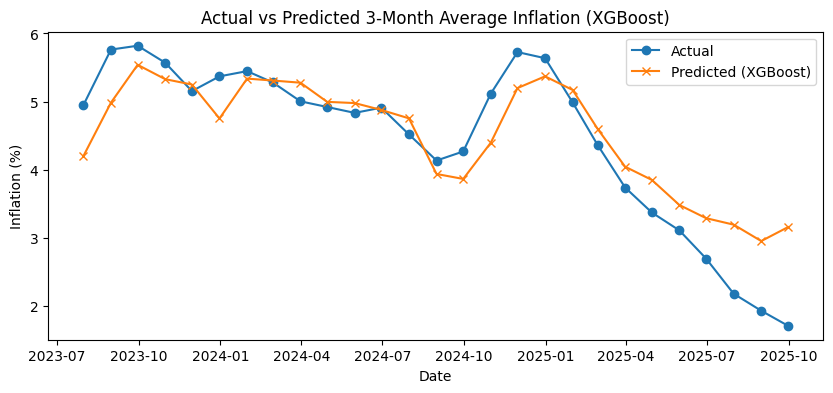

In [25]:
plt.figure(figsize=(10,4))
plt.plot(
    pred_xgb_df['Date'],
    pred_xgb_df['Actual_Inflation_3M'],
    label='Actual',
    marker='o'
)
plt.plot(
    pred_xgb_df['Date'],
    pred_xgb_df['Predicted_Inflation_3M_XGB'],
    label='Predicted (XGBoost)',
    marker='x'
)
plt.legend()
plt.title("Actual vs Predicted 3-Month Average Inflation (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.show()


In [26]:
X_latest = df_avg[feature_cols].iloc[[-1]]
X_latest_scaled = scalar_rf.transform(X_latest)
latest_xgb_pred = xgb.predict(X_latest_scaled)

print("XGBoost predicted next 3-month average inflation:", latest_xgb_pred[0])


XGBoost predicted next 3-month average inflation: 3.1548133


In [20]:
df_unsup=df.copy()

X_unsup = df_unsup[
    ['Inflation_Rate', 'M3_Growth', 'USD_INR', 'IIP_Growth', 'Call_Money_Rate']
]
scaler = StandardScaler()
X_unsup_scaled = scaler.fit_transform(X_unsup)

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df_unsup['KMeans_Cluster'] = kmeans.fit_predict(X_unsup_scaled)

cluster_summary = df_unsup.groupby('KMeans_Cluster')[
    ['Inflation_Rate', 'M3_Growth', 'USD_INR', 'IIP_Growth', 'Call_Money_Rate']
].mean()

print(cluster_summary)


                Inflation_Rate  M3_Growth    USD_INR  IIP_Growth  \
KMeans_Cluster                                                     
0                     2.947632   8.887511  73.433895    2.742588   
1                     5.848644  10.528401  78.224564    2.332744   
2                     5.496429  10.688705  64.239203    4.618081   

                Call_Money_Rate  
KMeans_Cluster                   
0                      5.970181  
1                      4.912030  
2                      6.954855  


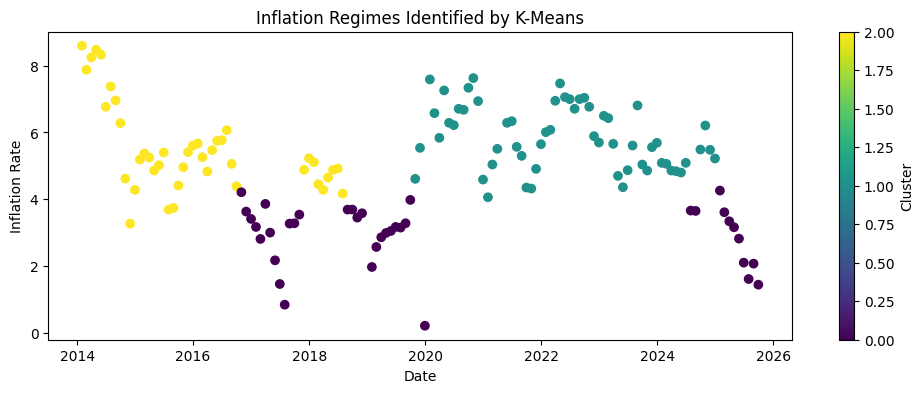

In [22]:
plt.figure(figsize=(12,4))
plt.scatter(
    df_unsup['Date'],
    df_unsup['Inflation_Rate'],
    c=df_unsup['KMeans_Cluster'],
    cmap='viridis'
)
plt.colorbar(label='Cluster')
plt.title("Inflation Regimes Identified by K-Means")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.show()

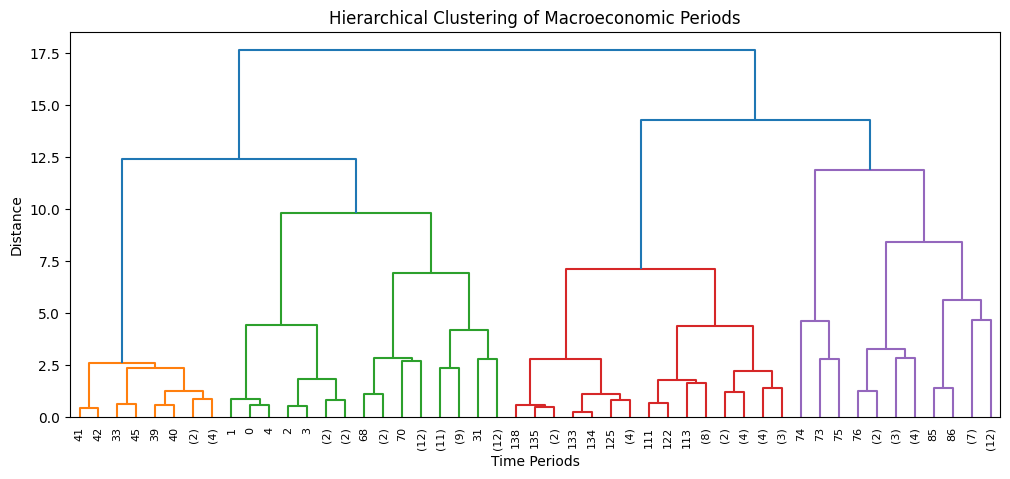

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_unsup_scaled, method='ward')

plt.figure(figsize=(12,5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering of Macroeconomic Periods")
plt.xlabel("Time Periods")
plt.ylabel("Distance")
plt.show()